In [5]:
import numpy as np
import cv2
from tqdm import tqdm
import time
import signal

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm
import time
import signal

def timeout_handler(num, stack):
    raise Exception("TIMEOUT")

def evaluate(student_file = 'sample_student', 
             path_to_training_images = 'data/training/images',
             training_csv_file = 'data/training/steering_angles.csv', 
             path_to_testing_images = 'data/training/images',
             testing_csv_file = 'data/training/steering_angles.csv', 
             time_limit = 600):
    
    '''
    Evaluate Student Submission for autonomous driving challenge. 
    Train and test studen't neural network implementation. 
    Training time is limited to time_limit seconds, if your code takes 
    longer than this, it will be terminated and no score will be recorded.
    '''
    
    #Import student methods:
    train = getattr(__import__(student_file, 'train'), 'train')
    predict = getattr(__import__(student_file, 'predict'), 'predict')
    
    #Setup timout handler - I think this will only work on unix based systems:
    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(time_limit)
    
    try:
        print("Training your network, start time: %s" % time.strftime("%H:%M:%S"))
        NN = train(path_to_images = path_to_training_images,
                   csv_file = training_csv_file)
        
    finally:
        signal.alarm(0)
        print("Ending Time: %s" % time.strftime("%H:%M:%S"))
        
    print('Training Complete! \n')
    
    print('Measuring performance...')
    ## Measure Performance:
    data = np.genfromtxt(testing_csv_file, delimiter = ',')
    frame_nums = data[:,0]
    steering_angles = data[:,1]

    predicted_angles = []
    for frame_num in tqdm(frame_nums):
        im_path = path_to_testing_images + '/' + str(int(frame_num)).zfill(4) + '.jpg'
        predicted_angles.append(predict(NN, im_path))
        
    RMSE = np.sqrt(np.mean((np.array(predicted_angles)- steering_angles)**2))
    RMSE = round(RMSE, 3)
    print('Test Set RMSE = ' + str(RMSE) + ' degrees.')

    return RMSE

def calculate_score(RMSE):
    score = 0
    if RMSE <= 12.5:
        score = 10
    elif RMSE <= 15:
        score = 9
    elif RMSE <= 20:
        score = 8
    elif RMSE <= 25:
        score = 7
    elif RMSE <= 30:
        score = 6
    elif RMSE <= 40:
        score = 5
    else:
        score = 4
    return score


if __name__ == '__main__':
    program_start = time.time()
    RMSE = evaluate(student_file='sample_student', 
                    path_to_training_images = 'data/training/images',
                    training_csv_file = 'data/training/steering_angles.csv', 
                    path_to_testing_images = 'data/training/images',
                    testing_csv_file = 'data/training/steering_angles.csv', 
                    time_limit = 600)
    
    score = calculate_score(RMSE)
    program_end = time.time()
    total_time = round(program_end - program_start,2)
    
    print("Execution time (seconds) = ", total_time)
    print("Score = ", score)

In [6]:
from matplotlib import pyplot as plt
from scipy import optimize
%pylab inline
import pylab as pl
from IPython import display

Populating the interactive namespace from numpy and matplotlib


In [7]:
student_file = 'sample_student'
path_to_training_images = 'data/training/images'
training_csv_file = 'data/training/steering_angles.csv'
path_to_testing_images = 'data/training/images'
testing_csv_file = 'data/training/steering_angles.csv'
time_limit = 600

In [8]:
data = np.genfromtxt(training_csv_file, delimiter = ',')
frame_nums = data[:,0]
steering_angles = data[:,1]
print(steering_angles.shape)

(1500,)


In [9]:
train_im = np.empty((1500, 3840))
for i in range(1500):
    im_full = cv2.imread(path_to_training_images + '/' 
                     + str(int(frame_nums[i])).zfill(4) + '.jpg')
    im_full = cv2.resize(im_full, (60, 64),interpolation = cv2.INTER_AREA)
    im_full = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
    im_full = np.ravel(im_full)
    im_full = im_full/255
    train_im[i] = im_full
# test_im = np.empty((500, 3840))
# for i in range(1000,1500):
#     im_full = cv2.imread(path_to_training_images + '/' 
#                      + str(int(frame_nums[i])).zfill(4) + '.jpg')
#     im_full = cv2.resize(im_full, (60, 64),interpolation = cv2.INTER_AREA)
#     im_full = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
#     im_full = np.ravel(im_full)
#     im_full = im_full/255
#     test_im[i-1000] = im_full

In [ ]:
# im_full = cv2.imread(path_to_training_images + '/' 
#                      + str(int(frame_nums[10])).zfill(4) + '.jpg')
# #inter_area better for shrinking
# im_full1 = cv2.resize(im_full, (60, 64),interpolation = cv2.INTER_AREA)
# im_full2 = cv2.resize(im_full, (60, 64))
# figure(0,(20,20))
# subplot(1,2,1)
# imshow(im_full1)
# subplot(1,2,2)
# imshow(im_full2)

In [10]:
steering_angles[879]
bins = numpy.linspace(-180,180,64)
print(bins)

[-180.         -174.28571429 -168.57142857 -162.85714286 -157.14285714
 -151.42857143 -145.71428571 -140.         -134.28571429 -128.57142857
 -122.85714286 -117.14285714 -111.42857143 -105.71428571 -100.
  -94.28571429  -88.57142857  -82.85714286  -77.14285714  -71.42857143
  -65.71428571  -60.          -54.28571429  -48.57142857  -42.85714286
  -37.14285714  -31.42857143  -25.71428571  -20.          -14.28571429
   -8.57142857   -2.85714286    2.85714286    8.57142857   14.28571429
   20.           25.71428571   31.42857143   37.14285714   42.85714286
   48.57142857   54.28571429   60.           65.71428571   71.42857143
   77.14285714   82.85714286   88.57142857   94.28571429  100.
  105.71428571  111.42857143  117.14285714  122.85714286  128.57142857
  134.28571429  140.          145.71428571  151.42857143  157.14285714
  162.85714286  168.57142857  174.28571429  180.        ]


In [11]:
stand = np.zeros((1,64))
stand[0][27:36]=[0.1,0.32,0.61,0.89,1,0.89,0.61,0.32,0.1]
# stand[1][31]=1
print(stand)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.1
  0.32 0.61 0.89 1.   0.89 0.61 0.32 0.1  0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.  ]]


In [12]:
angle_bins = np.zeros((1500, 64))
bins = numpy.linspace(-180,180,64)
pos = numpy.digitize(steering_angles, bins)
stand = np.zeros((1,64))
stand[0][27:36]=[0.1,0.32,0.61,0.89,1,0.89,0.61,0.32,0.1]
for i in range(1500):
    angle_bins[i] = np.roll(stand,pos[i]-32)
#     angle = steering_angles[i]
#     print(range(-180,180,5.625))

In [13]:
angle_bins[879]

array([0.61, 0.89, 1.  , 0.89, 0.61, 0.32, 0.1 , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.32])

In [14]:
angle_bins.shape

(1500, 64)

In [15]:
train_an = angle_bins
# test_an = angle_bins[1000:1500]
print(train_an.shape)

(1500, 64)


In [16]:
# im_full = cv2.imread(path_to_training_images + '/' + str(int(frame_nums[0])).zfill(4) + '.jpg')
# im_full2 = cv2.imread(path_to_training_images + '/' + str(int(frame_nums[10])).zfill(4) + '.jpg')
# im_full = cv2.resize(im_full, (60, 64)) 
# im_full2 = cv2.resize(im_full2, (60, 64)) 
# im_full = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
# im_full2 = cv2.cvtColor(im_full2, cv2.COLOR_BGR2GRAY)
# im_full = np.squeeze(np.reshape(im_full,60*64))
# im_full2= np.squeeze(np.reshape(im_full2,60*64))

In [17]:
print(train_im.shape)

(1500, 3840)


In [ ]:
# NN = NeuralNetwork()
# # grads = NN.computeGradients(X, y)
# # NN.setParams(grads)
# T = trainer(NN)
# T.train(train_im,train_an,test_im,test_an)

In [ ]:
# fig = figure(0, (12, 8))
# plot(test_an[499], linewidth = 3)
# grid(1)
# xlabel('Iterations')
# ylabel('Loss');

In [ ]:
# X = train_im
# y = train_an
# NN = Neural_Network(Lambda=0.0001)
# num_iterations = 5000
# alpha = 1e-4
# beta1= 0.9
# beta2= 0.999
# epsilon= 1e-08

# # # grads = NN.computeGradients(X = X, y = y)
# # m0 = np.zeros(len(grads)) #Initialize first moment vector
# # v0 = np.zeros(len(grads)) #Initialize second moment vector
# m0 = np.zeros(len(np.concatenate((NN.W1.ravel(), NN.W2.ravel()))))
# v0 = m0
# t = 0.0

# losses = [] #For visualization
# mt = m0
# vt = v0

# for i in tqdm(range(num_iterations)):
#     t += 1
#     grads = NN.computeGradients(X = X, y = y)
#     mt = beta1*mt + (1-beta1)*grads
#     vt = beta2*vt + (1-beta2)*grads**2
#     mt_hat = mt/(1-beta1**t)
#     vt_hat = vt/(1-beta2**t)
    
#     params = NN.getParams()
#     new_params = params - alpha*mt_hat/(sqrt(vt_hat)+epsilon)
#     NN.setParams(new_params)
    
#     losses.append(NN.costFunction(X = X, y = y))
#     if i%50==0:
#         losses.append(NN.costFunction(X = train_im, y = train_an))
#         pl.plot(losses)
#         display.clear_output(wait=True)
#         display.display(pl.gcf())
    
# fig = figure(0, (12, 8))
# plot(losses, linewidth = 3)
# grid(1)
# xlabel('Iterations')
# ylabel('Loss');

In [23]:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 384
        self.outputLayerSize = 64
        self.hiddenLayerSize = 30
        
#         #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
                #Weights (parameters)
#         limit = sqrt(6 / (self.inputLayerSize + self.hiddenLayerSize))
#         self.W1 = np.random.uniform(-limit, limit, (self.inputLayerSize, self.hiddenLayerSize))

#         limit = sqrt(6 / (self.hiddenLayerSize + self.outputLayerSize))
#         self.W2 = np.random.uniform(-limit, limit, (self.hiddenLayerSize, self.outputLayerSize))
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [18]:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 60*64
        self.outputLayerSize = 64
        self.hiddenLayerSize = 30

        # Glorot Initialization
        limit = sqrt(6 / (self.inputLayerSize + self.hiddenLayerSize))
        self.W1 = np.random.uniform(-limit, limit, (self.inputLayerSize, self.hiddenLayerSize))
        limit = sqrt(6 / (self.hiddenLayerSize + self.outputLayerSize))
        self.W2 = np.random.uniform(-limit, limit, (self.hiddenLayerSize, self.outputLayerSize))
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [24]:
def train_func(train_im, train_an):
    X = train_im
    y = train_an
    NN=Neural_Network(Lambda=0.0001)
    num_iterations = 2000
    #alpha = 1e-4
    alpha = 1e-3
    beta1= 0.4
    beta2= 0.97
    epsilon= 1e-08

    m0 = np.zeros(len(np.concatenate((NN.W1.ravel(), NN.W2.ravel()))))
    grads =  NN.computeGradients(X = X, y = y)
    m0 = np.zeros(len(grads)) #Initialize first moment vector
    print(m0.shape)
    v0 = m0
    t = 0.0

    losses = [] #For visualization
    mt = m0
    vt = v0

    for i in tqdm(range(num_iterations)):
        t += 1
        grads = NN.computeGradients(X = X, y = y)
        mt = beta1*mt + (1-beta1)*grads
        vt = beta2*vt + (1-beta2)*grads**2
        mt_hat = mt/(1-beta1**t)
        vt_hat = vt/(1-beta2**t)

        params = NN.getParams()
        new_params = params - alpha*mt_hat/(sqrt(vt_hat)+epsilon)
        NN.setParams(new_params)
        predicted_angles=[]
        Encodedpredict=NN.forward(X)
        losses.append(NN.costFunction(X = X, y = y))
        #     print(Encodedpredict)
        for predicted in Encodedpredict:
            predicted_a=bins[np.argmax(predicted)]   
            predicted_angles.append(predicted_a)  
        RMSE = np.sqrt(np.mean((np.array(predicted_angles) - steering_angles)**2))
    #print('Test Set RMSE = ' + str(RMSE) + ' degrees.')
    #         print("LOSS: {} -> Loss: {}".format(i, RMSE))
    
    return NN, losses



In [ ]:
im_full = cv2.imread(path_to_training_images + '/' 
                 + str(int(frame_nums[10])).zfill(4) + '.jpg')
#inter_area better for shrinking
im_full = cv2.resize(im_full, (60, 64),interpolation = cv2.INTER_AREA)
im_full = cv2.cvtColor(im_full, cv2.COLOR_BGR2GRAY)
im_full = np.ravel(im_full)
im_full = im_full/255
im_full.shape

In [ ]:
T,loss = NN.forward(im_full)
T

In [25]:
nn,loss = train_func(train_im,train_an)

ValueError: shapes (1500,3840) and (384,30) not aligned: 3840 (dim 1) != 384 (dim 0)

In [ ]:
nn.forward(im_full)

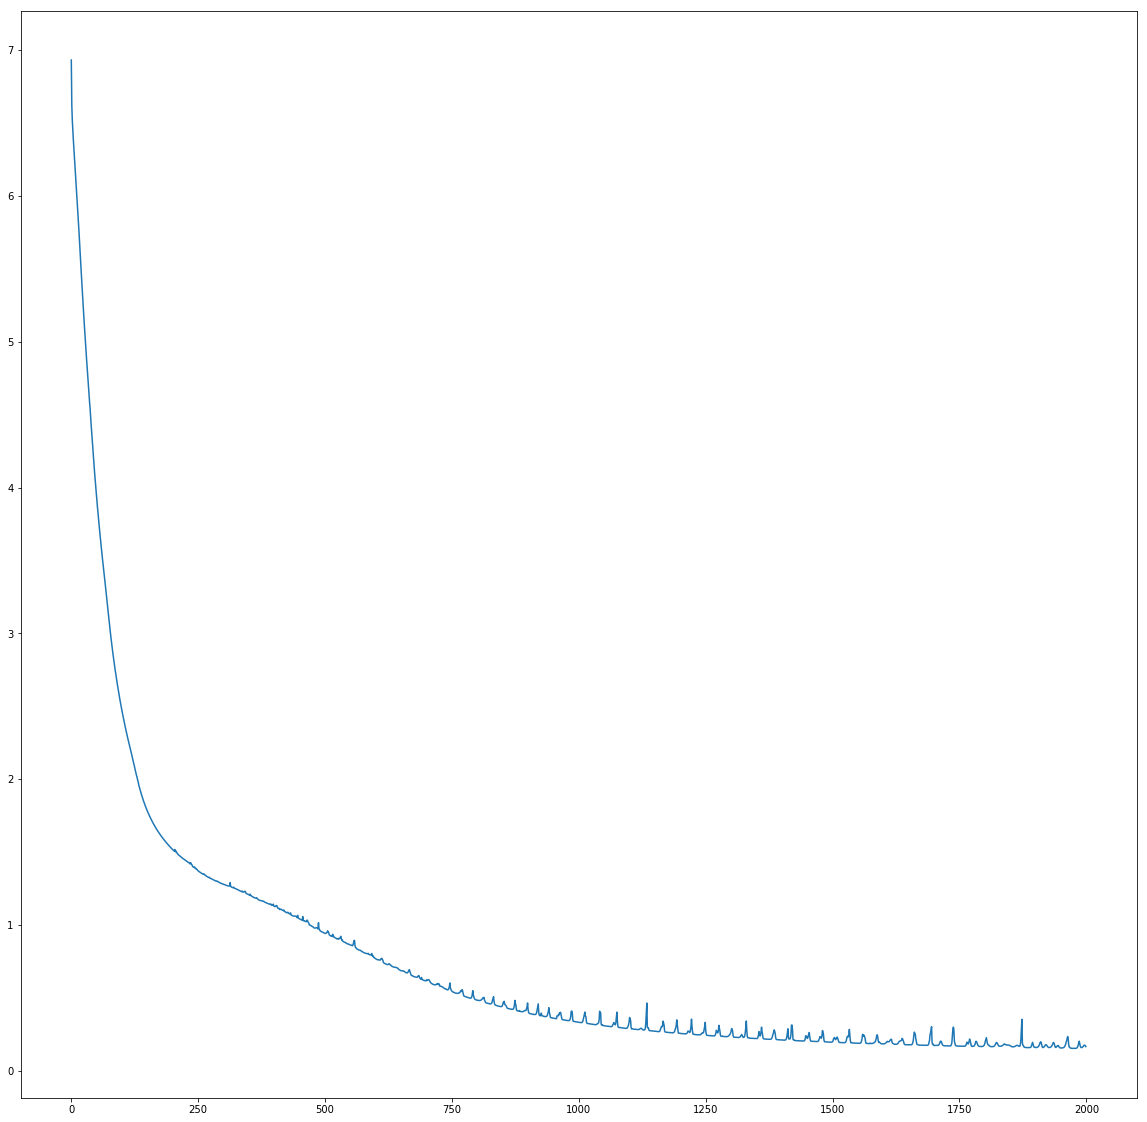

In [22]:
figure(0,(20,20))
plot(loss)